# 机器学习练习 4 - 神经网络

对于这个练习，我们将再次处理手写数字数据集，这次使用反向传播的前馈神经网络。 我们将通过反向传播算法实现神经网络成本函数和梯度计算的非正则化和正则化版本。 我们还将实现随机权重初始化和使用网络进行预测的方法。

由于我们在练习3中使用的数据集是相同的，所以我们将重新使用代码来加载数据。

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

由于我们以后需要这些（并将经常使用它们），我们先来创建一些有用的变量。

In [3]:
X = data['X']
y = data['y']
X.shape, y.shape#看下维度

((5000, 400), (5000, 1))

我们也需要对我们的y标签进行一次one-hot 编码。 one-hot 编码将类标签n（k类）转换为长度为k的向量，其中索引n为“hot”（1），而其余为0。 Scikitlearn有一个内置的实用程序，我们可以使用这个。

In [4]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

/home/xiaofang/anaconda3/envs/tfpy3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5000, 10)

In [5]:
y[0], y_onehot[0,:]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

我们要为此练习构建的神经网络具有与我们的实例数据（400 +偏置单元）大小匹配的输入层，25个单位的隐藏层（带有偏置单元的26个），以及一个输出层， 10个单位对应我们的一个one-hot编码类标签。 有关网络架构的更多详细信息和图像，请参阅“练习”文件夹中的PDF。

我们需要实现的第一件是评估一组给定的网络参数的损失的代价函数。 源函数在练习文本中（看起来很吓人）。 以下是代价函数的代码。

# sigmoid 函数

g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 前向传播函数

> (400 + 1) -> (25 + 1) -> (10)
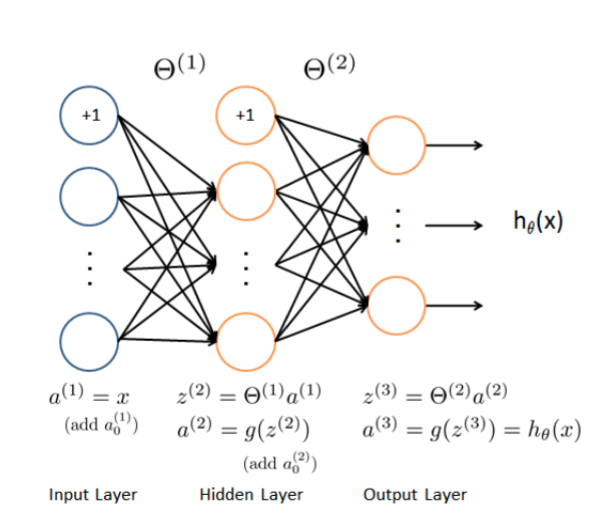

In [7]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

# 代价函数
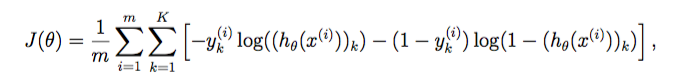

In [8]:
def cost(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))    
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1-y[i,:]), np.log(1 - h[i,:]))
        
        J += np.sum(first_term - second_term)
    J = J/m
    return J

这个Sigmoid函数我们以前使用过。 前向传播函数计算给定当前参数的每个训练实例的假设。 它的输出形状应该与y的一个one-hot编码相同。

In [9]:
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1
# 随机初始化完整网络参数大小的参数数组
params = (np.random.random(size=hidden_size*(input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

# 将参数数组解开为每个层的参数矩阵
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [10]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

代价函数在计算假设矩阵h之后，应用代价函数来计算y和h之间的总误差。

In [11]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)

6.784798697370256

# 正则化代价函数
我们的下一步是增加代价函数的正则化。  它实际上并不像看起来那么复杂 - 事实上，正则化术语只是我们已经计算出的代价的一个补充。 下面是修改后的代价函数。
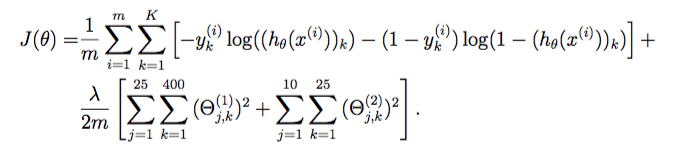

In [12]:
def cost(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    return J

In [13]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)

6.790143281852454

接下来是反向传播算法。 反向传播参数更新计算将减少训练数据上的网络误差。 我们需要的第一件事是计算我们之前创建的Sigmoid函数的梯度的函数。

In [14]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1-sigmoid(z)))

现在我们准备好实施反向传播来计算梯度。 由于反向传播所需的计算是代价函数中所需的计算过程，我们实际上将扩展代价函数以执行反向传播并返回代价和梯度。

In [21]:
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape) # (25, 401)维数组
    delta2 = np.zeros(theta2.shape) # (10, 26)维数组
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backgropagation
    for t in range(m):
        a1t = a1[t,:] #(1, 401)
        z2t = z2[t, :] #(1, 25)
        a2t = a2[t,:] #(1,26)
        ht = h[t,:] # (1, 10)
        yt = y[t,:]# (1,10)
        
        d3t = ht-yt #(1,10)
        z2t = np.insert(z2t, 0, values=np.ones(1)) # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))
        
        delta1 = delta1 + (d2t[:, 1:]).T * a1t
        
        delta2 = delta2 + d3t.T * a2t
    
    delta1 = delta1/m
    delta2 = delta2/m
    
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
        
    return J, grad

反向传播计算的最难的部分（除了理解为什么我们正在做所有这些计算）是获得正确矩阵维度。 顺便说一下，你容易混淆了A * B与np.multiply（A，B）使用。 基本上前者是矩阵乘法，后者是元素乘法（除非A或B是标量值，在这种情况下没关系）。 无论如何，让我们测试一下，以确保函数返回我们期望的。

In [22]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J, grad

(6.790143281852454,
 array([-0.02340877,  0.        ,  0.        , ...,  0.20379913,
         0.15623967,  0.13596173]))

我们终于准备好训练我们的网络，并用它进行预测。 这与以往的具有多类逻辑回归的练习大致相似。

In [27]:
from scipy.optimize import minimize

fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate),
               method='TNC',
               jac=True,
               options={'maxiter':250})
fmin

     fun: 0.5183477295215007
     jac: array([0.00224968, 0.        , 0.        , ..., 0.00018625, 0.00043602,
       0.00086262])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 177
     nit: 15
  status: 1
 success: True
       x: array([ 0.4918069 ,  0.11706866,  0.01229425, ...,  2.21923227,
       -0.24660164,  2.82582567])

由于目标函数不太可能完全收敛，我们对迭代次数进行了限制。 我们的总代价已经下降到0.5以下，这是算法正常工作的一个很好的指标。 让我们使用它发现的参数，并通过网络转发，以获得一些预测。

让我们使用它找到的参数，并通过网络前向传播以获得预测。

In [28]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)],
                             (hidden_size, (input_size+1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):],
                             (num_labels, (hidden_size+1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]])


最后，我们可以计算准确度，看看我们训练完毕的神经网络效果怎么样。

In [29]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 97.6%


我们已经成功地实施了一个基本的反向传播神经网络，并用它来分类手写数字图像。 在下一个练习中，我们将介绍另一个强大的监督学习算法，支持向量机。